In [5]:
from math import pi
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from datetime import date
from datetime import datetime
import simdkalman
import talib
import numpy as np

In [6]:
df = pd.read_csv('rts_2209_0412.txt') #это тики с финама


In [7]:
len(df)

8332439

In [8]:
df.head()

,<DATE>,<TIME>,<LAST>,<VOL>,<ID>,<OPER>
0,20181022,100000,112650.0,1,2147231168,B
1,20181022,100000,112680.0,4,2147231169,B
2,20181022,100000,112680.0,1,2147231170,B
3,20181022,100000,112700.0,1,2147231174,B
4,20181022,100000,112800.0,1,2147231177,B


In [9]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline

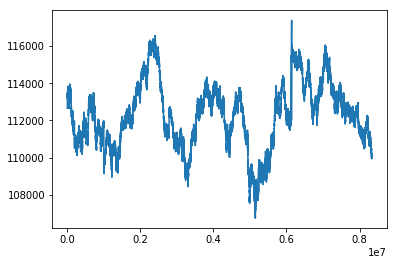

In [10]:
plt.plot(df['<LAST>'])

In [11]:
#сожмем тики, а также выгрзим их в list - так удобней во многих случаях.
volume_l = list(df['<VOL>'])
sig_l = list(df['<OPER>'])
ri_l = list(df['<LAST>'])
vol_sum_l = []
vol_sum_sig_l = []
#попробуем удалить все значения, когда не меняется в стакане ри

tt = 10 #показатель тик так - если поставить 20, то сожмет все тики между которыми 20 рублей и тд

vol_sum = 0
vol_sum_sig = 0
ch_lst = []
vpin_l = []
prev_x = 0
oper_num =0
oper_l = []
prev_price = 0
for i,x in enumerate(ri_l):
    current_vol = volume_l[i]
    vol_sum = vol_sum+current_vol
    oper_num+=1
    if sig_l[i]=='S':
        vol_sum_sig-=current_vol
    else:
        vol_sum_sig+=current_vol
    if abs(x-prev_x)>=tt: 
        ch_lst.append(1)
        vol_sum_l.append(vol_sum)
        vol_sum_sig_l.append(vol_sum_sig)
        vpin_l.append(vol_sum_sig/vol_sum)
        oper_l.append(oper_num)
        vol_sum = 0
        vol_sum_sig = 0
        oper_num=0
        prev_x = x
    else:
        ch_lst.append(0)
        vol_sum_l.append(0)
        vol_sum_sig_l.append(0)
        vpin_l.append(0)
        oper_l.append(0)
    
df['change_ri'] = ch_lst
df['vol_sum'] = vol_sum_l
df['vol_sum_sig'] = vol_sum_sig_l
df['vpin']=vpin_l
df['oper_num'] = oper_l

print(len(df))

8332439


In [12]:
df = df[df['change_ri']>0] #оставим только строчки, где произошло изменение цены. промежуточные тики выкинем

In [13]:
#df = df[df['oper_num']>1] #на тот случай если мы не хотим учитывать левые выбросы по 1 операции на тик

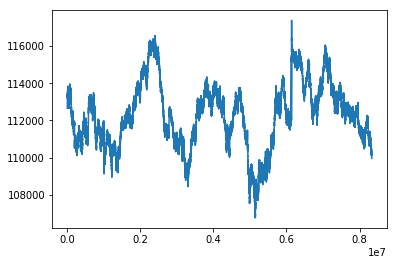

In [14]:
plt.plot(df['<LAST>'])

In [15]:
len(df)

1784446

In [16]:
8332439/1784446

4.669482293103854

In [298]:
#размер данных соктаился в 4.7 раза. их можно еще значительно ужать если увеличить показатель тик така сверху

In [299]:
df.head()

,<DATE>,<TIME>,<LAST>,<VOL>,<ID>,<OPER>,change_ri,vol_sum,vol_sum_sig,vpin,oper_num
0,20181022,100000,112650.0,1,2147231168,B,1,1,1,1.0,1
1,20181022,100000,112680.0,4,2147231169,B,1,4,4,1.0,1
3,20181022,100000,112700.0,1,2147231174,B,1,2,2,1.0,2
4,20181022,100000,112800.0,1,2147231177,B,1,1,1,1.0,1
5,20181022,100000,112830.0,1,2147231178,B,1,1,1,1.0,1


In [17]:
#Добавим впин за последние 10, 20, 100, 500 периодов
#vpin в моем понимании как соотношение обьемов покупки/продажи
#это отношение обьемов со знаком к обьмема то есть -1 (сплошные продажи) 1 (покупки) 0 (продажи покупки поровну)

In [18]:
step_l = [2,3,4,5,10,20,50,100,500,1000,5000]
for x in step_l:
    df['vpin_'+str(x)]=df.vol_sum_sig.rolling(x).sum()/df.vol_sum.rolling(x).sum()

In [19]:

step_l = [5,10,20,50,100,500,1000]
for x in step_l:
    df['rsi_'+str(x)]=talib.RSI(df['<LAST>'],x)

In [20]:
#Теперь кальманы и его отклонения от средней и его отклонения от средней

In [21]:
kf = simdkalman.KalmanFilter(
    state_transition = [[1]],
    process_noise = [[.01]],
    observation_model = [[1]],
    observation_noise = [[1.8]])

In [22]:
k_result = kf.compute(df['<LAST>'].values,filtered=True,n_test = 1) 
df['kalman']=k_result.filtered.observations.mean #значение фильтра кальмана

In [23]:

kf = simdkalman.KalmanFilter(
    state_transition = [[1]],
    process_noise = [[.01]],
    observation_model = [[1]],
    observation_noise = [[6]])
k_result_2 = kf.compute(df['<LAST>'].values,filtered=True,n_test = 1) 
df['kalman_slow']=k_result_2.filtered.observations.mean #значение фильтра кальмана



In [24]:
#расстояние между двумя медленными быстрыми кальманами
df['delta_kalman_slow_fast']=df['kalman']-df['kalman_slow']

In [25]:
df['kalman_var'] = df['<LAST>']-df['kalman']  #разница между средней и ценой

In [26]:
df['var_mean_50'] = df.kalman_var.rolling(50).mean() #среднее отклонение цены от кальмана 
df['var_mean_100']= df.kalman_var.rolling(100).mean()
df['var_mean_300']= df.kalman_var.rolling(300).mean()

In [27]:
df['kf_var_50']=df['kalman_var']/df['var_mean_50'] #Отношение текущего отклонения к среднему
df['kf_var_100']=df['kalman_var']/df['var_mean_100']

In [28]:
df['kalman_var_abs'] = abs(df['<LAST>']-df['kalman'])  #разница между средней и ценой.


In [29]:
df['var_mean_50_abs'] = df.kalman_var_abs.rolling(50).mean() #среднее отклонение цены от кальмана 
df['var_mean_100_abs']= df.kalman_var_abs.rolling(100).mean()
df['var_mean_300_abs']= df.kalman_var_abs.rolling(300).mean()

In [30]:
df['kf_var_50_abs']=df['kalman_var']/df['var_mean_50_abs'] #Отношение текущего отклонения к среднему 
df['kf_var_100_abs']=df['kalman_var']/df['var_mean_100_abs']



In [31]:
df['std_kalman_50']=df['kalman_var'].rolling(50).std()
df['std_kalman_100']=df['kalman_var'].rolling(100).std()

In [32]:
import talib #наклон индиктора линейная регрессия
df['ang_lr_50']=talib.LINEARREG_ANGLE(df['<LAST>'].values,50) #индиктор линейная регрессия. показывает средний 
df['ang_lr_200']=talib.LINEARREG_ANGLE(df['<LAST>'].values,200)
df['ang_lr_500']=talib.LINEARREG_ANGLE(df['<LAST>'].values,500)
df['ang_lr_1000']=talib.LINEARREG_ANGLE(df['<LAST>'].values,1000)
df['ang_lr_5000']=talib.LINEARREG_ANGLE(df['<LAST>'].values,5000)


In [33]:
#Обьемы средние за разные период
df['mean_vol_20']=df['vol_sum'].rolling(20).mean()
df['mean_vol_100']=df['vol_sum'].rolling(100).mean()
df['mean_vol_500']=df['vol_sum'].rolling(500).mean()
df['mean_vol_1000']=df['vol_sum'].rolling(1000).mean()

In [34]:
df['oper_num_10']=df['oper_num'].rolling(10).mean() #количество операций
df['oper_num_20']=df['oper_num'].rolling(20).mean()
df['oper_num_100']=df['oper_num'].rolling(100).mean()
df['oper_num_500']=df['oper_num'].rolling(500).mean()


In [35]:
for x in [2,3,5,10,50]: #изменение цены (дельта цены за разные периоды)
    df['price_delta_'+str(x)]=df['<LAST>']-df['<LAST>'].shift(x)
    df['price_std1_'+str(x)]=df['price_delta_'+str(x)].rolling(1000).std()
    df['price_std_'+str(x)]=df['price_delta_'+str(x)].rolling(500).std()
    df['price_std2_'+str(x)]=df['price_delta_'+str(x)].rolling(100).std()
    df['price_std5_'+str(x)]=df['price_delta_'+str(x)].rolling(50).std()

In [36]:
for x in [1,2,3,5,10,50]: #"наклон" кальман
    df['kalman_delta_'+str(x)]=df['kalman']-df['kalman'].shift(x)

In [37]:
#еще придумал одну фичу - берем 100 тиков цены и смотрим сколько это секунд - то есть чем больше сек, тем меньше интенсивность 
df['sec_100']=df['<TIME>']-df['<TIME>'].shift(100)
df['sec_500']=df['<TIME>']-df['<TIME>'].shift(500)

In [38]:
#Это очень востребованные фичи - расстрояние между ценой и минмаксом за периодом а также из расстояние вообще
for x in [50,100,300,500,1000]:
    df[f'min_{x}_dist']=df['<LAST>']-df['<LAST>'].rolling(x).min()
    df[f'max_{x}_dist']=df['<LAST>'].rolling(x).max()-df['<LAST>']
    df[f'min_max_{x}_dist']=df['<LAST>'].rolling(x).max()-df['<LAST>'].rolling(x).min()

In [39]:
from scipy.stats import skew #ассиметрия распределения
for x in [2,3,5,10,50]: #изменение цены (дельта цены за разные периоды)
    df['price_skew_'+str(x)]=df['price_delta_'+str(x)].rolling(500).skew()
    df['price_skew1_'+str(x)]=df['price_delta_'+str(x)].rolling(1000).skew()

In [40]:
for x in [2,3,5,10,50]: #дельта ассиметрии
    df['price_skew_dif_'+str(x)]=(df['price_skew_'+str(x)]-df['price_skew_'+str(x)].shift(1))*1000
    df['price_skew1_dif_'+str(x)]=(df['price_skew1_'+str(x)]-df['price_skew1_'+str(x)].shift(1))*1000

In [41]:
df.dropna(axis=0, how='any',inplace=True)

In [42]:
columns_to_del = list(df.columns[3:9]) #грохнем первые колонки с ценой, временем и тд
print([c for c in columns_to_del])
for x in columns_to_del:
    try:
        del df[x]
    except:
        pass

['<VOL>', '<ID>', '<OPER>', 'change_ri', 'vol_sum', 'vol_sum_sig']


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779447 entries, 22650 to 8332438
Columns: 121 entries, <DATE> to price_skew1_dif_50
dtypes: float64(118), int64(3)
memory usage: 1.6 GB


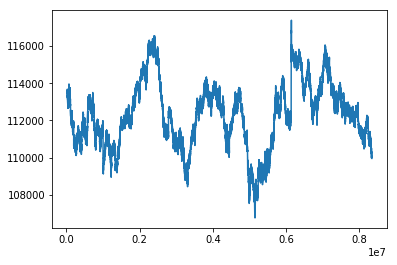

In [44]:
plt.plot(df['<LAST>'])

In [45]:
#создадим три разных датафрейма для дневной, вечерней и поздно-вечерней сессии

In [46]:
df_p1 =df[df['<TIME>']>110000]
df_p1 =df_p1[df_p1['<TIME>']<160000]

In [47]:
df_p2=df[df['<TIME>']>160000]
df_p2=df_p2[df_p2['<TIME>']<183000]

In [48]:
df_p3=df[df['<TIME>']>191500]
df_p3=df_p3[df_p3['<TIME>']<233000]

In [49]:
len(df),len(df_p1),len(df_p2),len(df_p3)

(1779447, 677317, 423527, 323352)

In [50]:
import pickle
nm='RI10'
pickle.dump(df,open('data_frame_'+nm+'_p_all.pcl','wb'))
pickle.dump(df_p1,open('data_frame_'+nm+'_p1.pcl','wb'))
pickle.dump(df_p2,open('data_frame_'+nm+'_p2.pcl','wb'))
pickle.dump(df_p3,open('data_frame_'+nm+'_p3.pcl','wb'))
print('data_frame_'+nm+'_p_all.pcl')

data_frame_RI10_p_all.pcl
